In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [199]:
from statsmodels.tsa.ar_model import AutoReg,ar_select_order

# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()

# weather example
weather = pd.read_csv('./dataset/PittsburghWeather.csv',index_col='Date',parse_dates=True)
weather = weather.drop(['tmin','prcp'],axis=1)
weather = weather[weather.index > '2010-01-01']
weather = weather.asfreq('d')
weather = weather.fillna(method='ffill')
print(weather.info())
print(weather.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3651 entries, 2010-01-02 to 2019-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmax    3651 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB
None
            tmax
Date            
2010-01-02  20.0
2010-01-03  18.0
2010-01-04  23.0
2010-01-05  24.0
2010-01-06  26.0


In [200]:
px.line(weather,x=weather.index,y='tmax')

# Auto Regression Model

In [201]:
# 建立AR model
# 切分訓練和測試資料(8:2)
print(len(weather) * 0.8)
print(len(weather) * 0.2)
train_weather = weather.iloc[:2920]
test_weather = weather.iloc[2920:]

# Define training model for 730 days and White's covariance
ar_weather = AutoReg(train_weather['tmax'],730).fit(cov_type='HC0')

start = len(train_weather)
end = len(train_weather) + len(test_weather) - 1
prediction = ar_weather.predict(start=start,end=end,dynamic=True)

2920.8
730.2


C:\Users\Mashiro\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



# 測試集和預測的比較

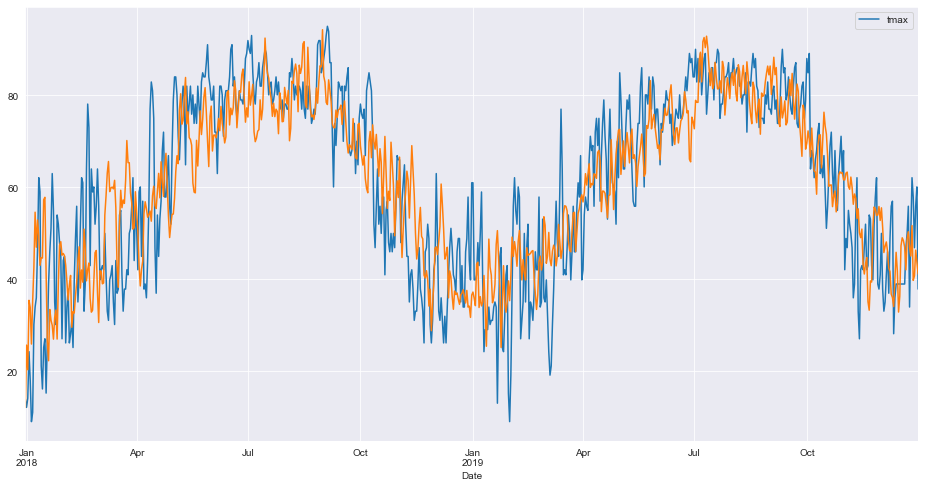

In [202]:
fig, ax = plt.subplots()
sns.mpl.rc('figure',figsize=(16, 8))

ax = test_weather.plot(ax=ax)
ax = prediction.plot(ax=ax)

# stock

In [203]:
# stock example
stock = pd.read_csv('./dataset/appl2.csv',index_col='Date',parse_dates=True)
stock = stock.asfreq('d')
stock = stock.fillna(method='ffill')
print(stock.info())
print(stock.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345 entries, 2014-01-02 to 2014-12-12
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   345 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB
None
                Price
Date                 
2014-01-02  77.445395
2014-01-03  77.045575
2014-01-04  77.045575
2014-01-05  77.045575
2014-01-06  74.896972


In [204]:
px.line(stock,x=stock.index,y='Price')

In [205]:
# 建立AR model
# 切分訓練和測試資料(8:2)
print(len(stock) * 0.8)
print(len(stock) * 0.2)
train_stock = stock.iloc[:276]
test_stock = stock.iloc[276:]

# Define training model for 730 days and White's covariance
ar_stock = AutoReg(stock['Price'],100).fit(cov_type='HC0')

start = len(train_stock)
end = len(train_stock) + len(test_stock) - 1
prediction = ar_stock.predict(start=start,end=end,dynamic=True)

276.0
69.0


C:\Users\Mashiro\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



# 測試集和預測的比較

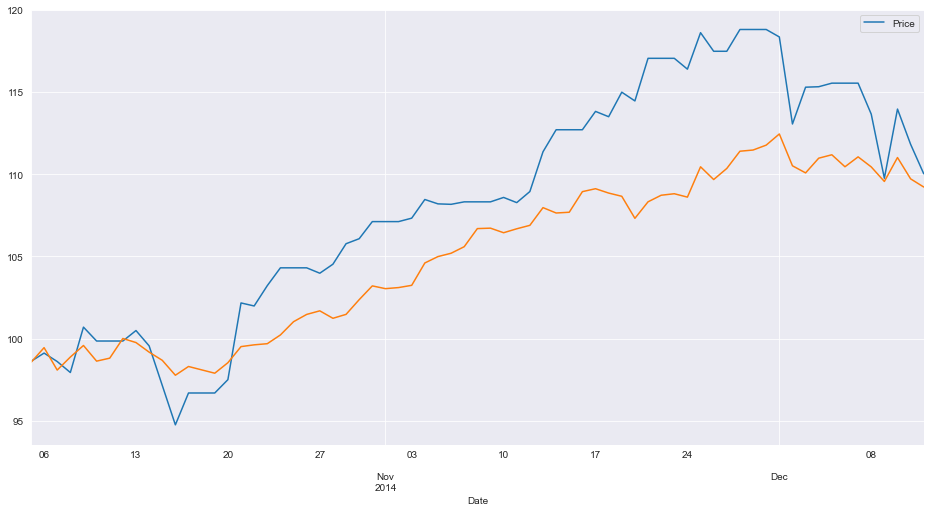

In [206]:
fig, ax = plt.subplots()
sns.mpl.rc('figure',figsize=(16, 8))

ax = test_stock.plot(ax=ax)
ax = prediction.plot(ax=ax)

# 測試集和預測的比較 + 未來60天的走勢
可以發現，stock的資料集並不夠準確，因為資料及沒有符合stationary

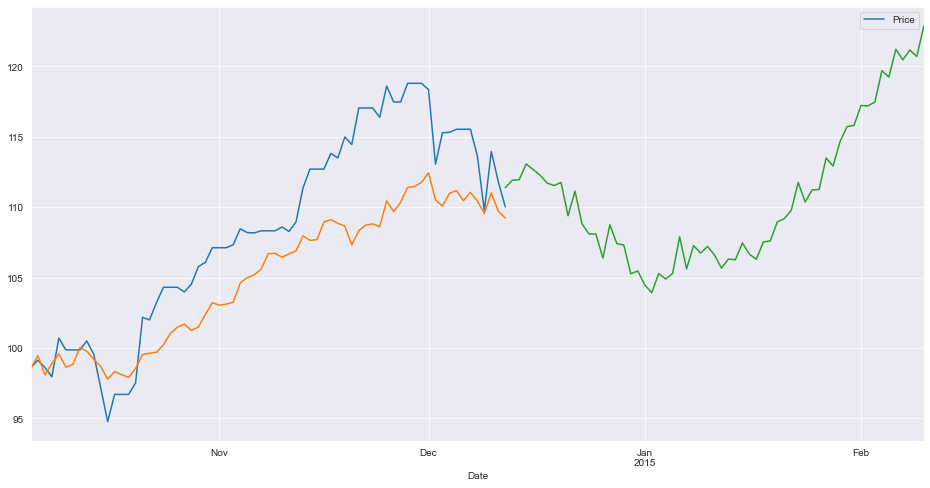

In [207]:
fig, ax = plt.subplots()
sns.mpl.rc('figure',figsize=(16, 8))

# Plot testing data with prediction
ax = test_stock.plot(ax=ax) # Blue
ax = prediction.plot(ax=ax) # Orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+60, dynamic=True)
ax = forecast.plot(ax=ax,) #  Green

# Augmented Dickey-Fuller Test
時間序列資料在建立ARIMA前必須先做初步的檢驗，是否為stationary。<br>
The Augmented Dickey-Fuller Test tells us whether our results are stationary.<br>
If the P-Value is very small that means there is a very low probability that our reults are random.<br>
大概取0.05做閥值

In [208]:
from statsmodels.tsa.stattools import adfuller

def adf_test(TimeSerie_Data):
    test = adfuller(TimeSerie_Data,autolag='AIC')
    test_result = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    return test_result

In [209]:
# weather test
adf_test(weather)

Test Statistic                   -3.734447
p-value                           0.003654
#Lags Used                       15.000000
Number of Observations Used    3635.000000
dtype: float64

In [210]:
# stock test
adf_test(stock)

Test Statistic                  -0.325875
p-value                          0.921759
#Lags Used                       0.000000
Number of Observations Used    344.000000
dtype: float64

# Weather通過Augmented Dickey-Fuller Test
# Stock沒通過

# ARIMA Model for Weather
https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/<br>
https://medium.com/%E5%AE%85%E7%94%B7%E9%9B%9C%E5%AD%B8%E7%AD%86%E8%A8%98/data-science-%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E5%88%86%E6%9E%90%E5%88%9D%E6%8E%A2-1-6d13c2a673c4

In [211]:
from pmdarima import auto_arima
auto_arima(weather, seasonal=False, m=1, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=25393.962, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40845.483, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=36359.899, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=25489.324, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=25975.625, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=25444.711, Time=1.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=25395.841, Time=1.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=25947.960, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=25403.847, Time=0.29 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25403.133, Time=0.77 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=25397.969, Time=0.54 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=25384.770, Time=1.89 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=25472.151, Time=1.08 sec
 ARIMA(2,0,1)(0,0,0)[0] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3651
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -12686.385
Date:                Thu, 02 Sep 2021   AIC                          25384.770
Time:                        01:34:47   BIC                          25421.986
Sample:                             0   HQIC                         25398.024
                               - 3651                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2374      0.085      2.777      0.005       0.070       0.405
ar.L1          1.3498      0.031     43.007      0.000       1.288       1.411
ar.L2         -0.3537      0.031    -11.494      0.000      -0.414      -0.293
ma.L1         -0.5625      0.031    -18.373      0.000      -0.622      -0.502
ma.L2         -0.2707      0.020    -13.230      0.000      -0.311      -0.231
sigma2        61.0075      1.234     49.446      0.000      58.589      63.426
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               191.68
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.26
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [212]:
from statsmodels.tsa.arima_model import ARIMA

# Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
model=ARIMA(train_weather,order=(2,0,2))
model_fit=model.fit()
model_fit.summary()

C:\Users\Mashiro\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   tmax   No. Observations:                 2920
Model:                     ARMA(2, 2)   Log Likelihood              -10138.897
Method:                       css-mle   S.D. of innovations              7.790
Date:                Thu, 02 Sep 2021   AIC                          20289.794
Time:                        01:34:48   BIC                          20325.670
Sample:                    01-02-2010   HQIC                         20302.716
                         - 12-30-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.3343      6.478      9.005      0.000      45.637      71.031
ar.L1.tmax     1.3644      0.035     38.625      0.000       1.295       1.434
ar.L2.tmax    -0.3678      0.035    -10.520      0.000      -0.436      -0.299
ma.L1.tmax    -0.5672      0.035    -16.090      0.000      -0.636      -0.498
ma.L2.tmax    -0.2721      0.026    -10.654      0.000      -0.322      -0.222
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0055           +0.0000j            1.0055            0.0000
AR.2            2.7036           +0.0000j            2.7036            0.0000
MA.1            1.1398           +0.0000j            1.1398            0.0000
MA.2           -3.2246           +0.0000j            3.2246            0.5000
-----------------------------------------------------------------------------
"""

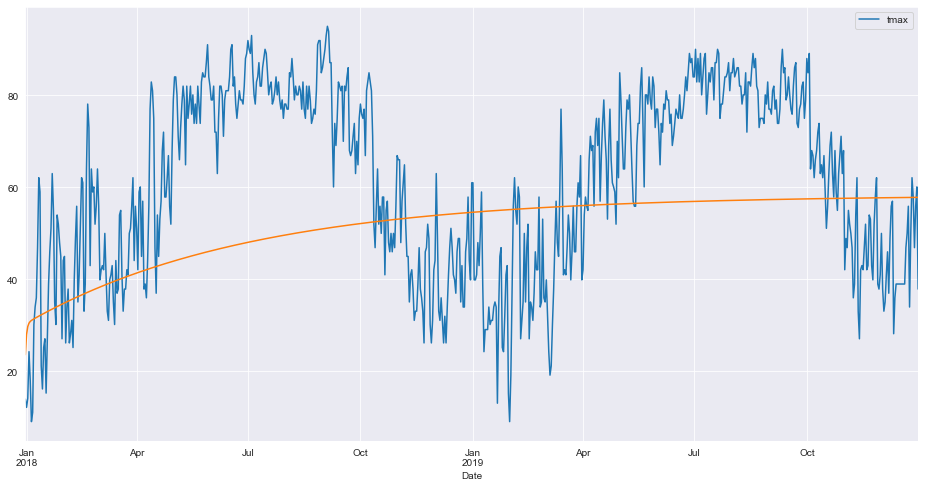

In [213]:
fig, ax = plt.subplots()
sns.mpl.rc('figure',figsize=(16, 8))

start = len(train_weather)
end = len(train_weather) + len(test_weather) - 1
prediction = model_fit.predict(start=start,end=end,dynamic=True)

# Plot testing data with prediction
ax = test_weather.plot(ax=ax) # Blue
ax = prediction.plot(ax=ax) # Orange

# Predict 60 days into the future
# forecast = model.predict(start=end, end=end+60, dynamic=True)
# ax = forecast.plot(ax=ax,) #  Green

# 可以看到由於weather具有season factor效果不佳，改用SARIMA 